<a href="https://colab.research.google.com/github/fralfaro/MAT281/blob/main/docs/labs/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N°10

**Objetivo**: Analizar y modelar series temporales de datos delictivos en Montreal, aplicando métodos estadísticos y de aprendizaje automático para la predicción.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


### Conjunto de datos



<img src="https://svgsilh.com/svg/3350822.svg" width="350"  align="center"/>


El conjunto de datos **`interventionscitoyendo.csv`** proviene del *Service de police de la Ville de Montréal* (SPVM) y contiene el registro de todos los **actos delictivos ocurridos en Montreal entre 2015 y agosto de 2020**.

Cada incidente está clasificado en **categorías generales de delito** e incluye información contextual como la **ubicación geográfica**, la **fecha y hora** del suceso, así como otros atributos relevantes para el análisis.

Este dataset resulta especialmente útil para estudios de **series temporales**, ya que permite agrupar los delitos por intervalos de tiempo (días, semanas, meses) y analizar patrones de comportamiento delictual en la ciudad.

> **Nota**: Puede consultarse más información oficial en el [portal de datos abiertos de Montreal](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).


In [89]:
# librerias

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [90]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [91]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT281/main/docs/labs/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [92]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()



El objetivo de este laboratorio es realizar un **análisis integral** del conjunto de datos, aplicando técnicas de visualización y modelado de series temporales. Para ello, se deben abordar las siguientes tareas:

1. **Visualizar las series temporales** \$y\_{si}, ; i=1,2,3,4\$, generando gráficos que permitan identificar patrones, tendencias y estacionalidades.



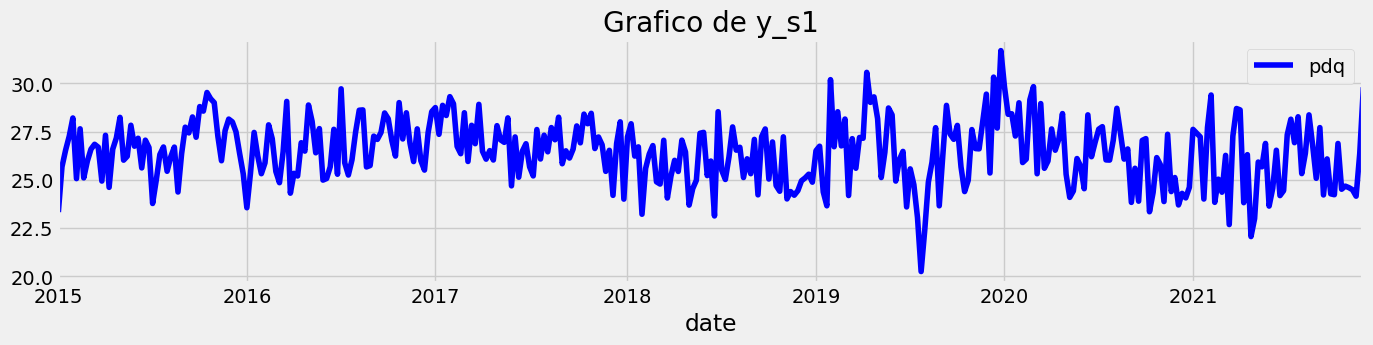

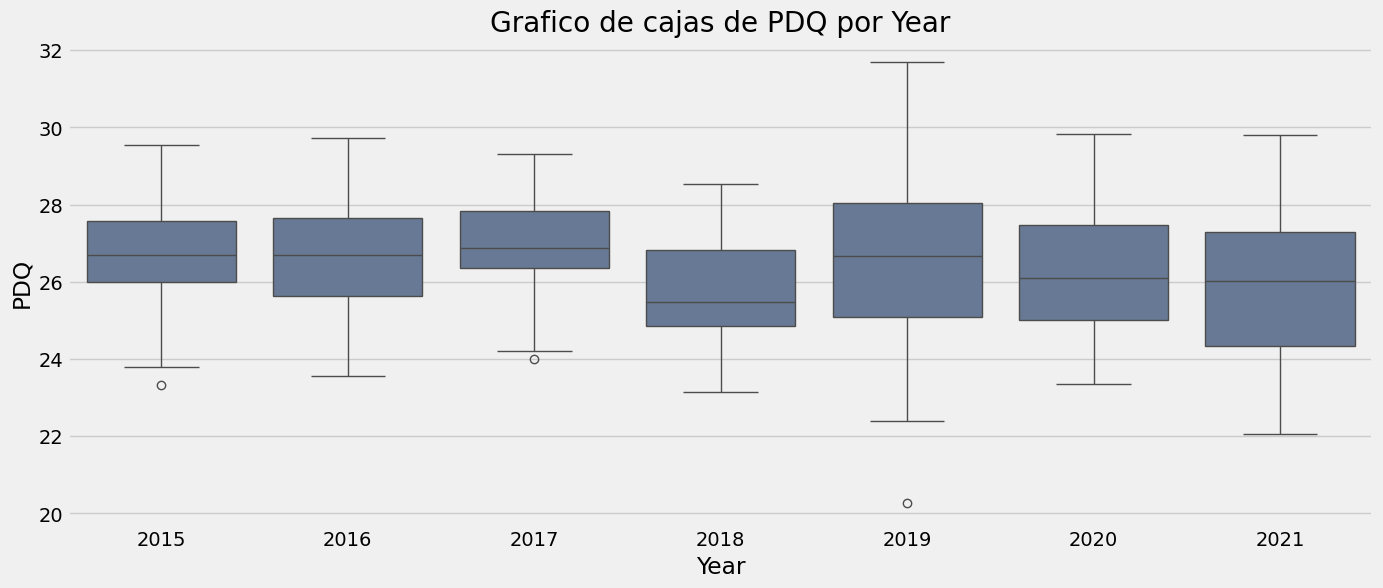

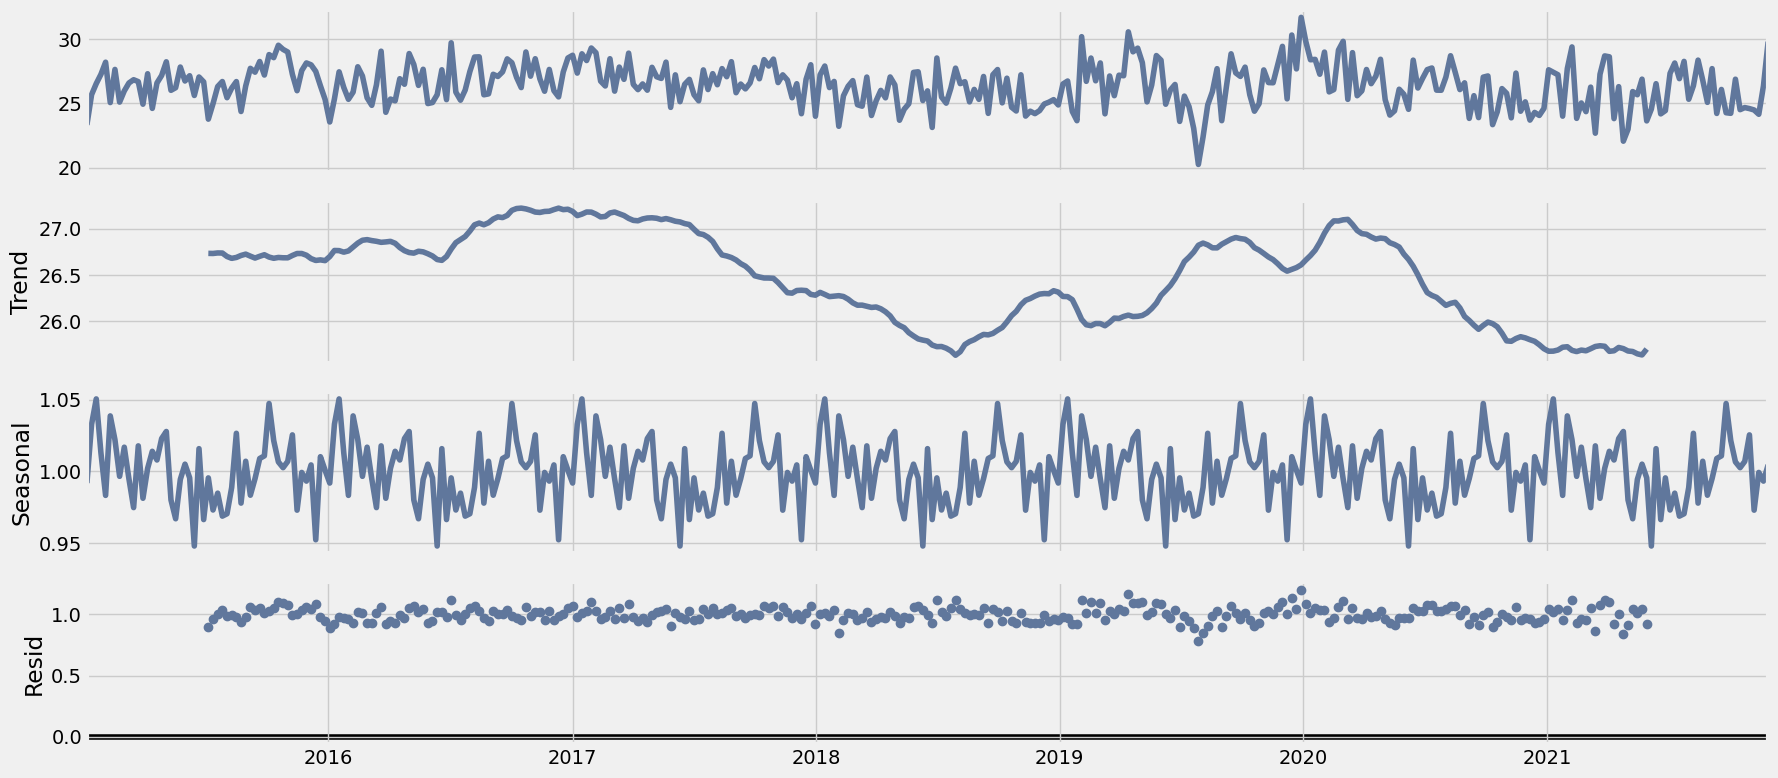

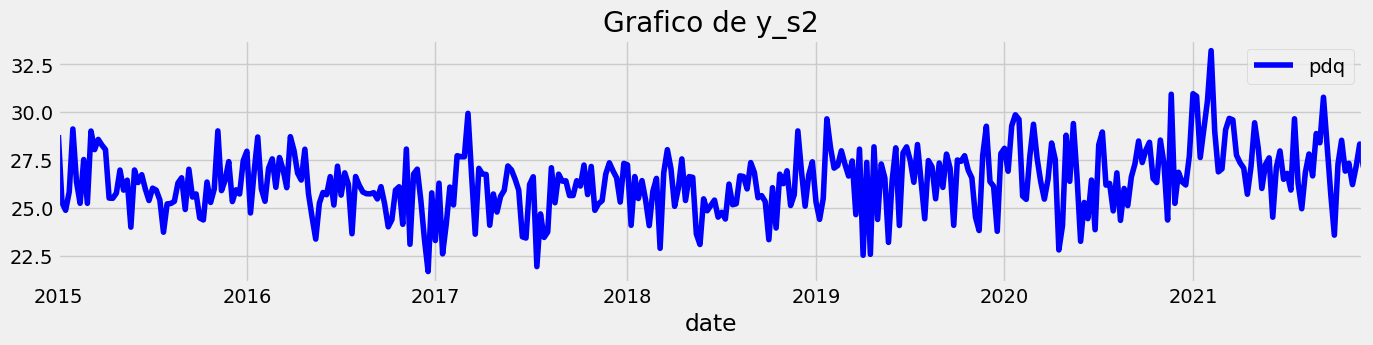

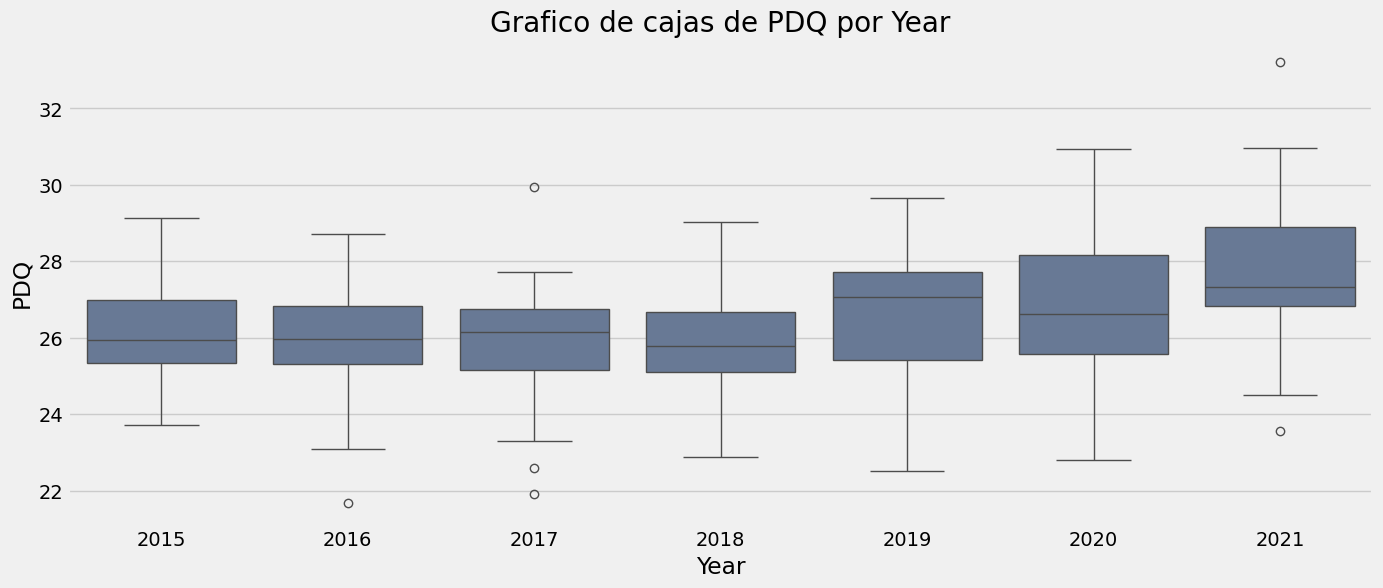

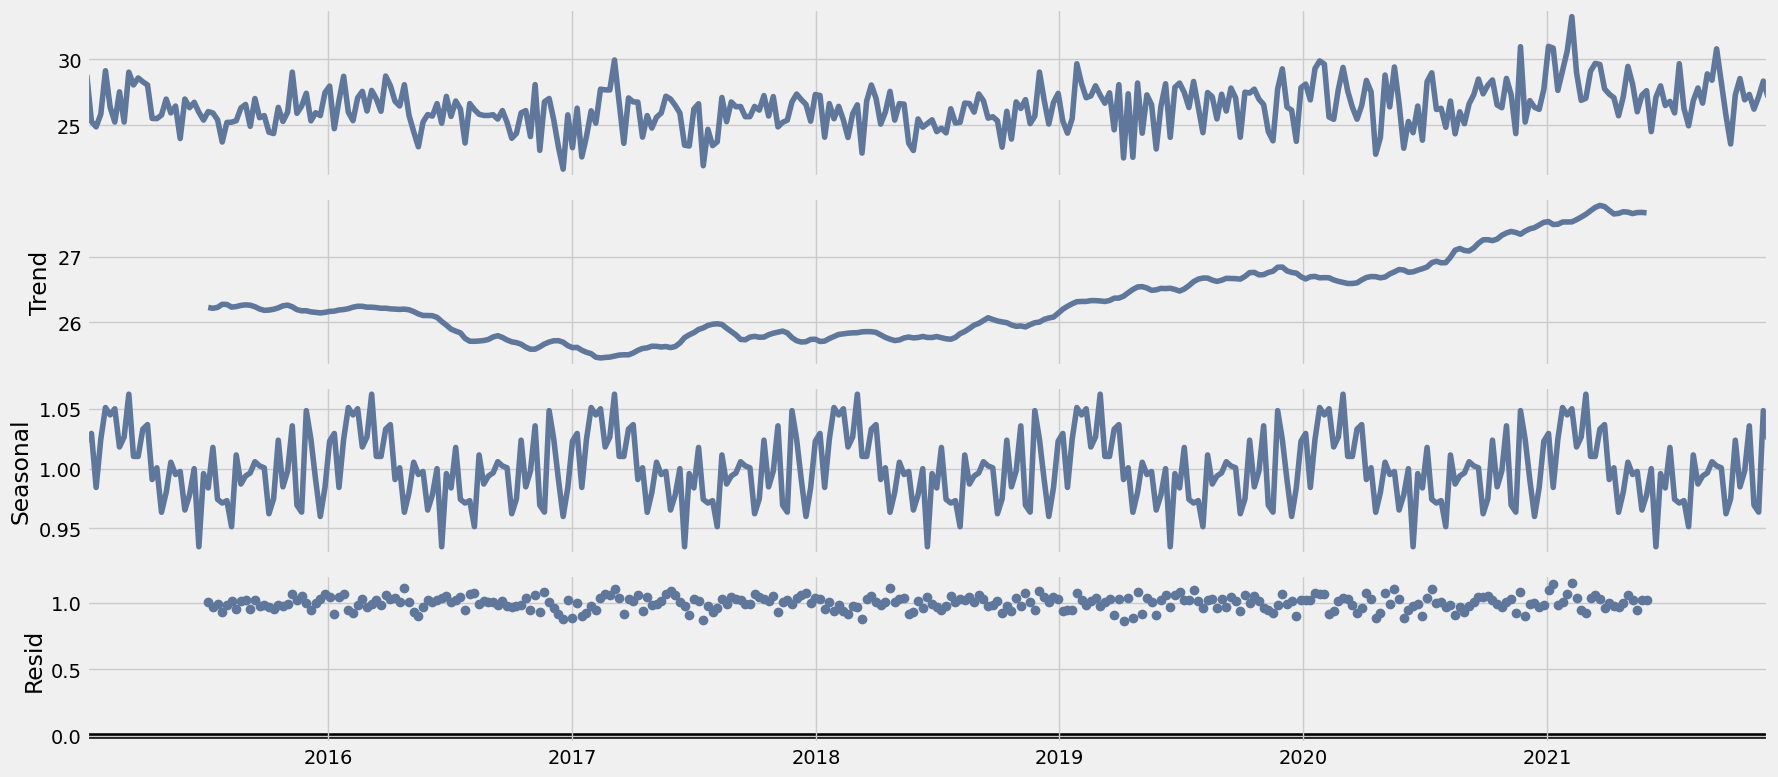

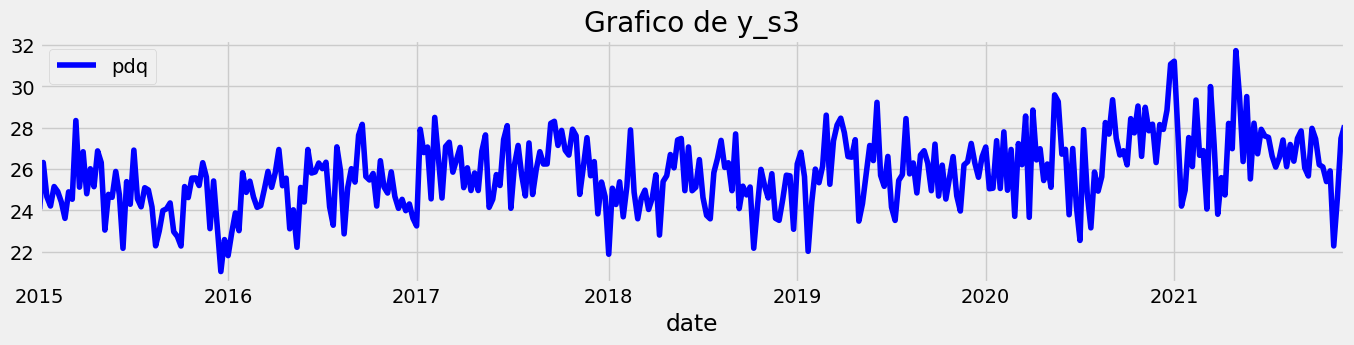

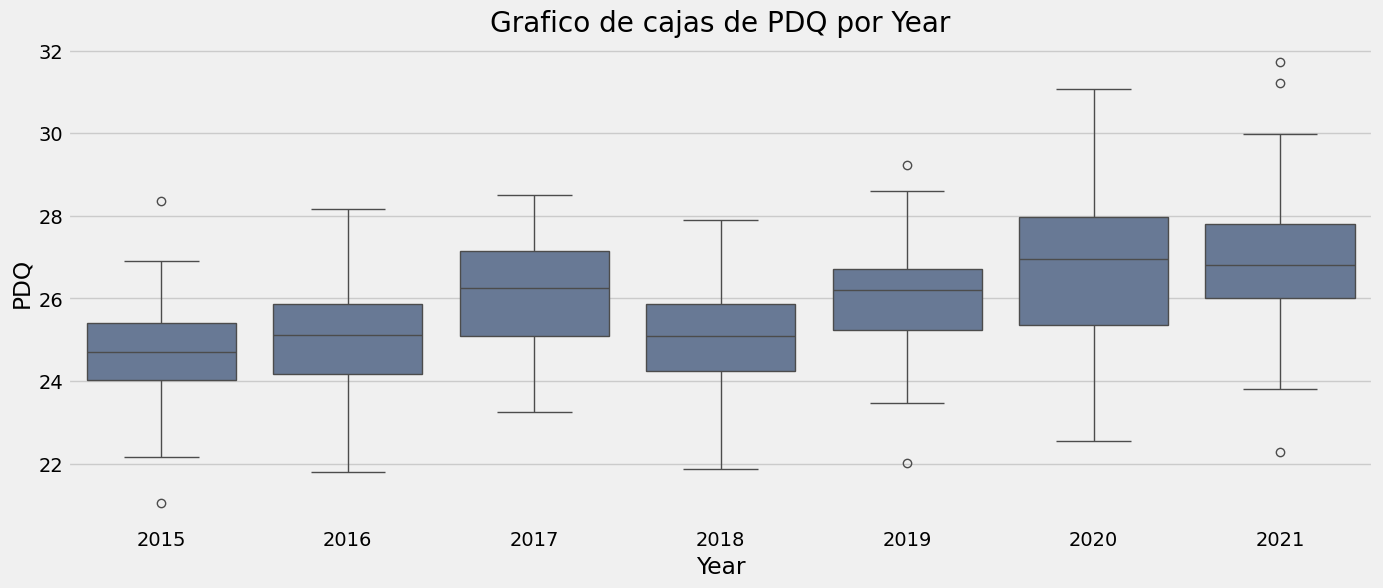

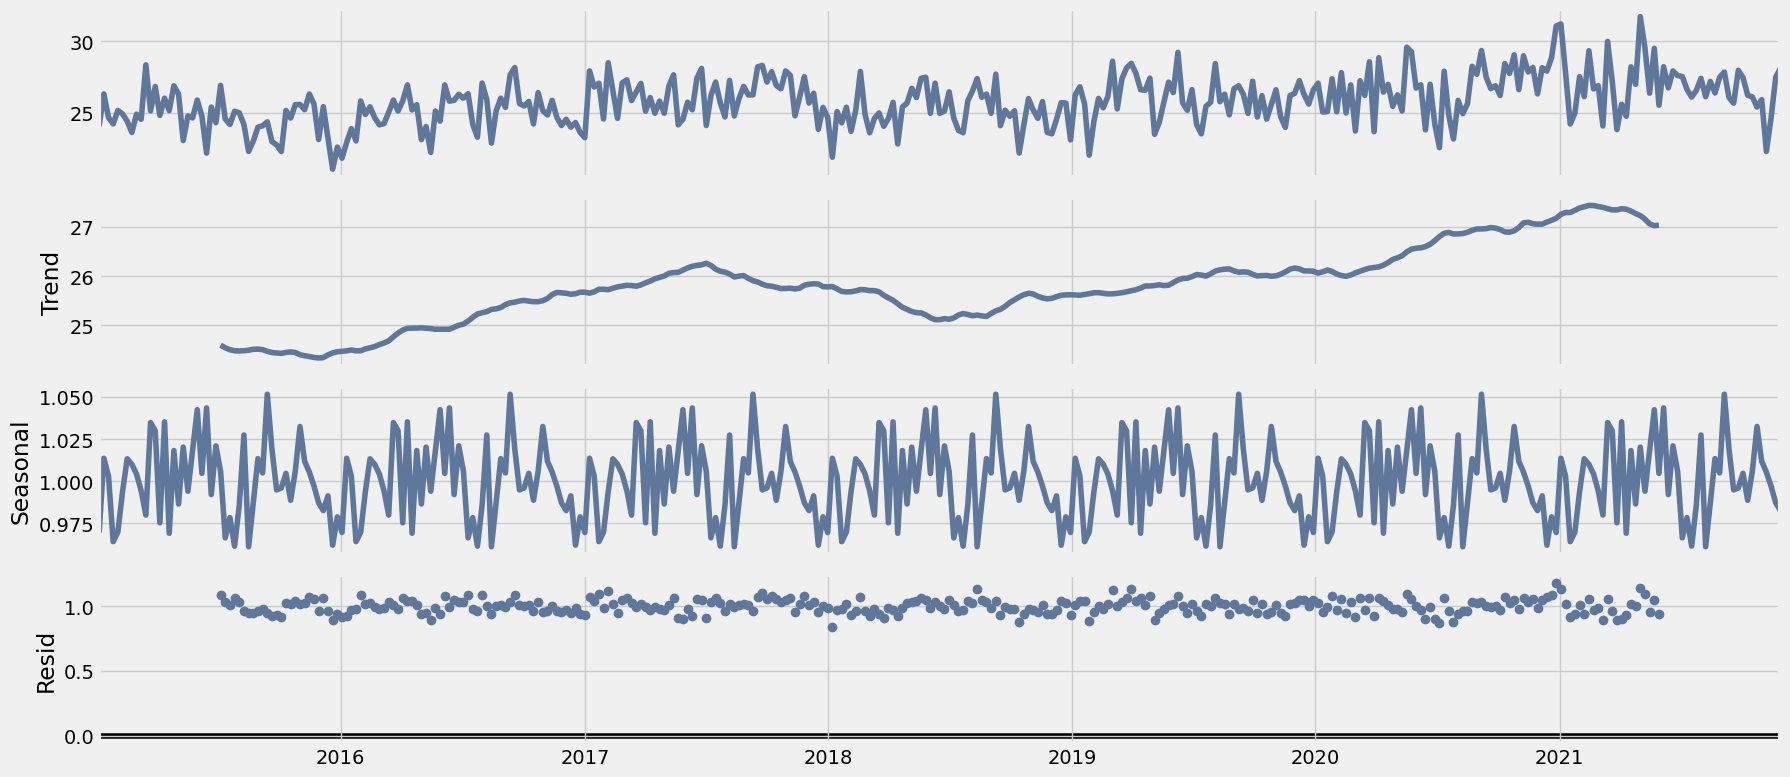

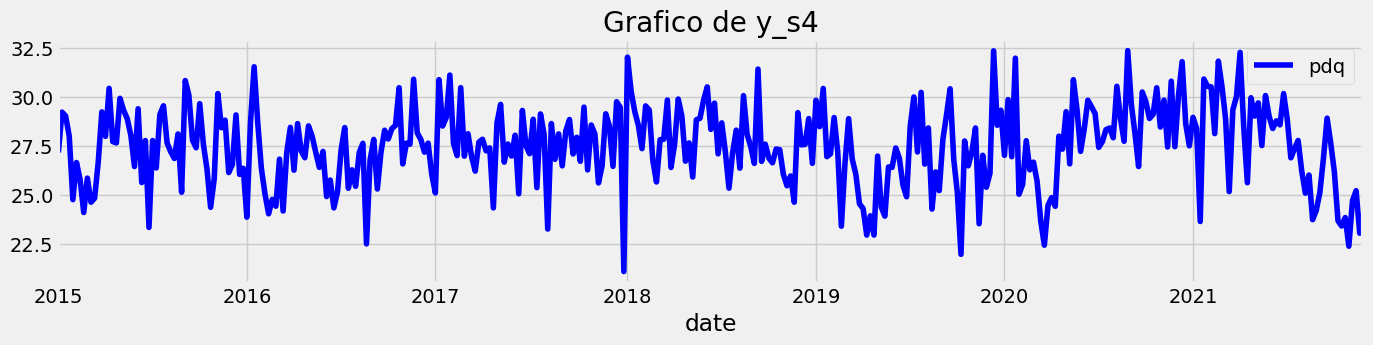

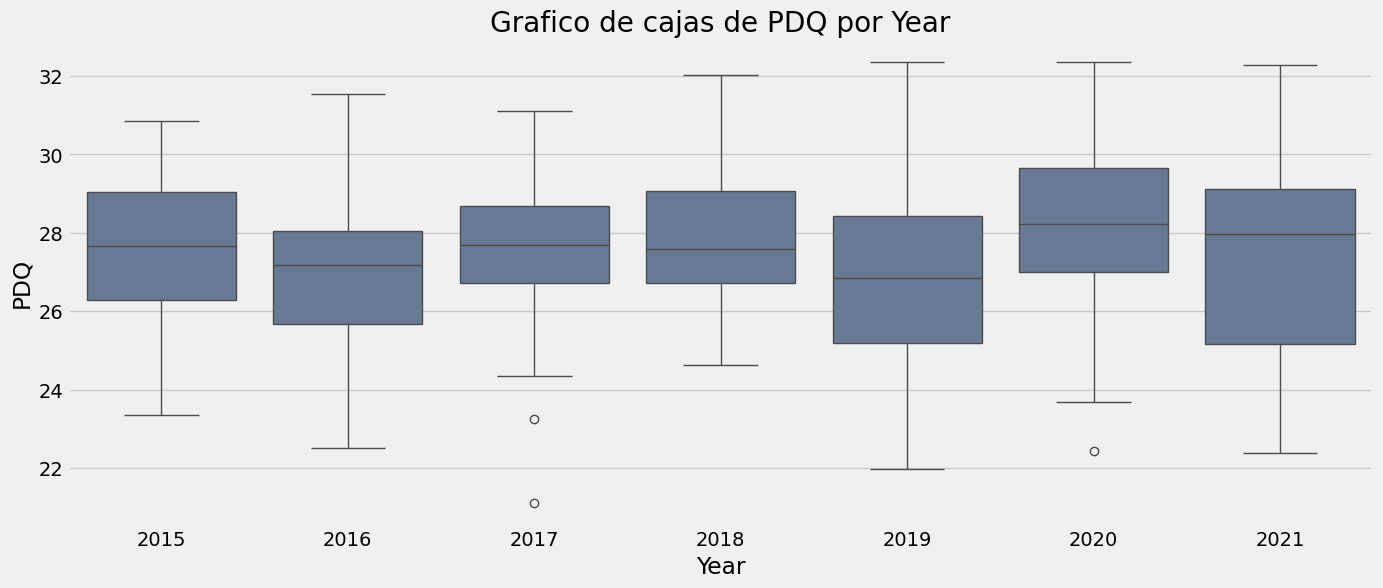

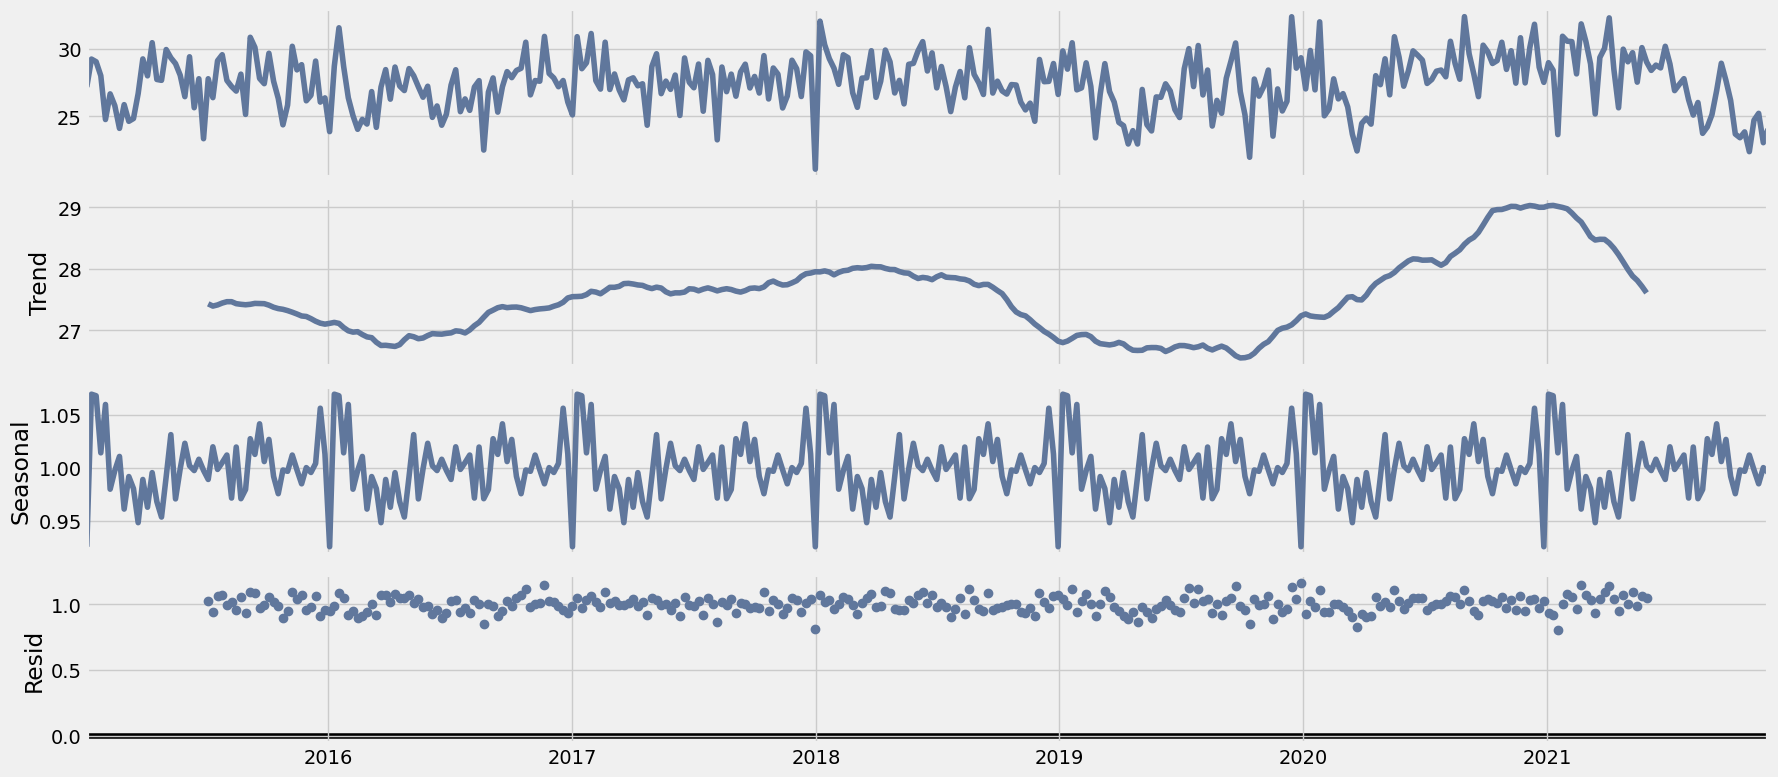

In [93]:
from pylab import rcParams
import statsmodels.api as sm
import matplotlib.pyplot as plt
y_s1.plot(figsize=(15, 3),color = 'blue')
plt.title("Grafico de y_s1")
plt.show()
fig, ax= plt.subplots(figsize=(15, 6))
sns.boxplot(x=y_s1.index.year, y=y_s1["pdq"], data=y_s1, ax=ax)
plt.xlabel("Year")
plt.ylabel("PDQ")
plt.title("Grafico de cajas de PDQ por Year")
plt.show()
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_s1, model='multiplicative')
fig = decomposition.plot()
plt.show()
y_s2.plot(figsize=(15, 3),color = 'blue')
plt.title("Grafico de y_s2")
plt.show()
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x=y_s2.index.year, y=y_s2["pdq"], data=y_s2, ax=ax)
plt.xlabel("Year")
plt.ylabel("PDQ")
plt.title("Grafico de cajas de PDQ por Year")
plt.show()
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_s2, model='multiplicative')
fig = decomposition.plot()
plt.show()
y_s3.plot(figsize=(15, 3),color = 'blue')
plt.title("Grafico de y_s3")
plt.show()
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x=y_s3.index.year, y=y_s3["pdq"], data=y_s3, ax=ax)
plt.xlabel("Year")
plt.ylabel("PDQ")
plt.title("Grafico de cajas de PDQ por Year")
plt.show()
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_s3, model='multiplicative')
fig = decomposition.plot()
plt.show()
y_s4.plot(figsize=(15, 3),color = 'blue')
plt.title("Grafico de y_s4")
plt.show()
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x=y_s4.index.year, y=y_s4["pdq"], data=y_s4, ax=ax)
plt.xlabel("Year")
plt.ylabel("PDQ")
plt.title("Grafico de cajas de PDQ por Year")
plt.show()
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_s4, model='multiplicative')
fig = decomposition.plot()
plt.show()



1. Seleccione una de las series temporales \$y\_{si}, ; i=1,2,3,4\$ y desarrolle lo siguiente:

* **Análisis exploratorio**: examine la serie elegida identificando patrones, tendencias y posibles estacionalidades.
* **Modelado con SARIMA**: ajuste un modelo \$SARIMA(p,d,q) \times (P,D,Q,S)\$ probando distintas configuraciones de hiperparámetros. Compare resultados, seleccione la mejor configuración y justifique su elección.
* **Validación del modelo**: evalúe los residuos del modelo óptimo y determine si se comportan como **ruido blanco**.

> **Nota**: Utilice como `target_date` = `'2021-01-01'`. Recuerde que la columna de valores se llama `pdq`.



In [94]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params


    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')

    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]

        return y_train, y_test

    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        return model_fit

    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )

        return df_temp

    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model

        return df_metrics

# definir parametros

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

--- Grafico de la Serie Temporal y_s1 (Mefait) ---


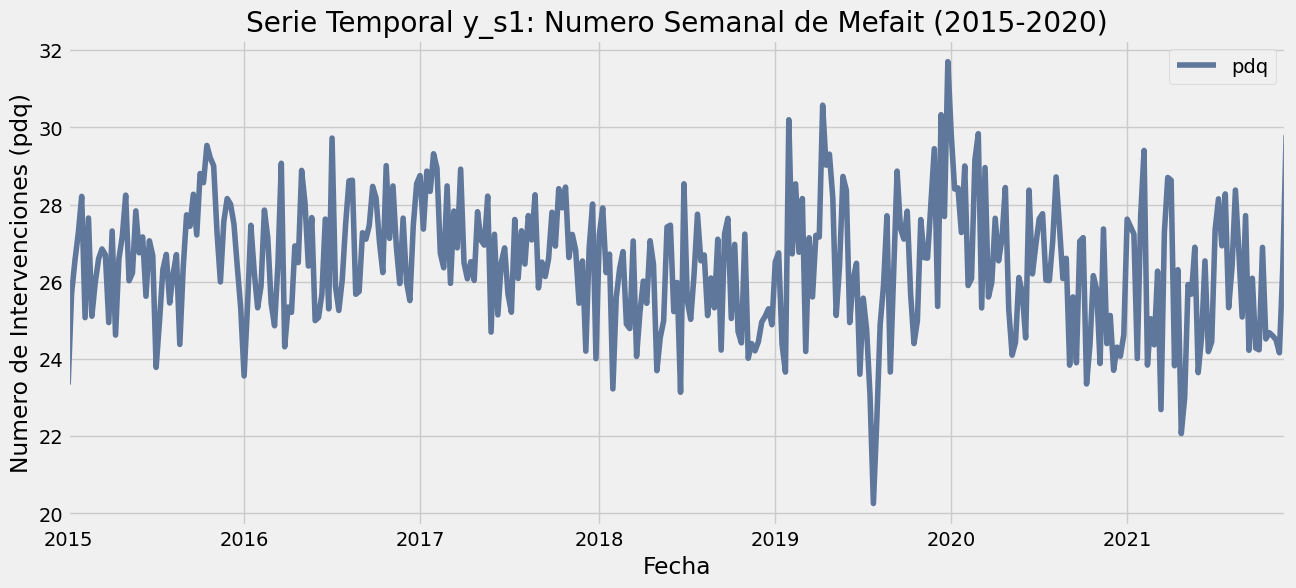


--- Descomposicion de la Serie y_s1 (Estacionalidad S=52) ---


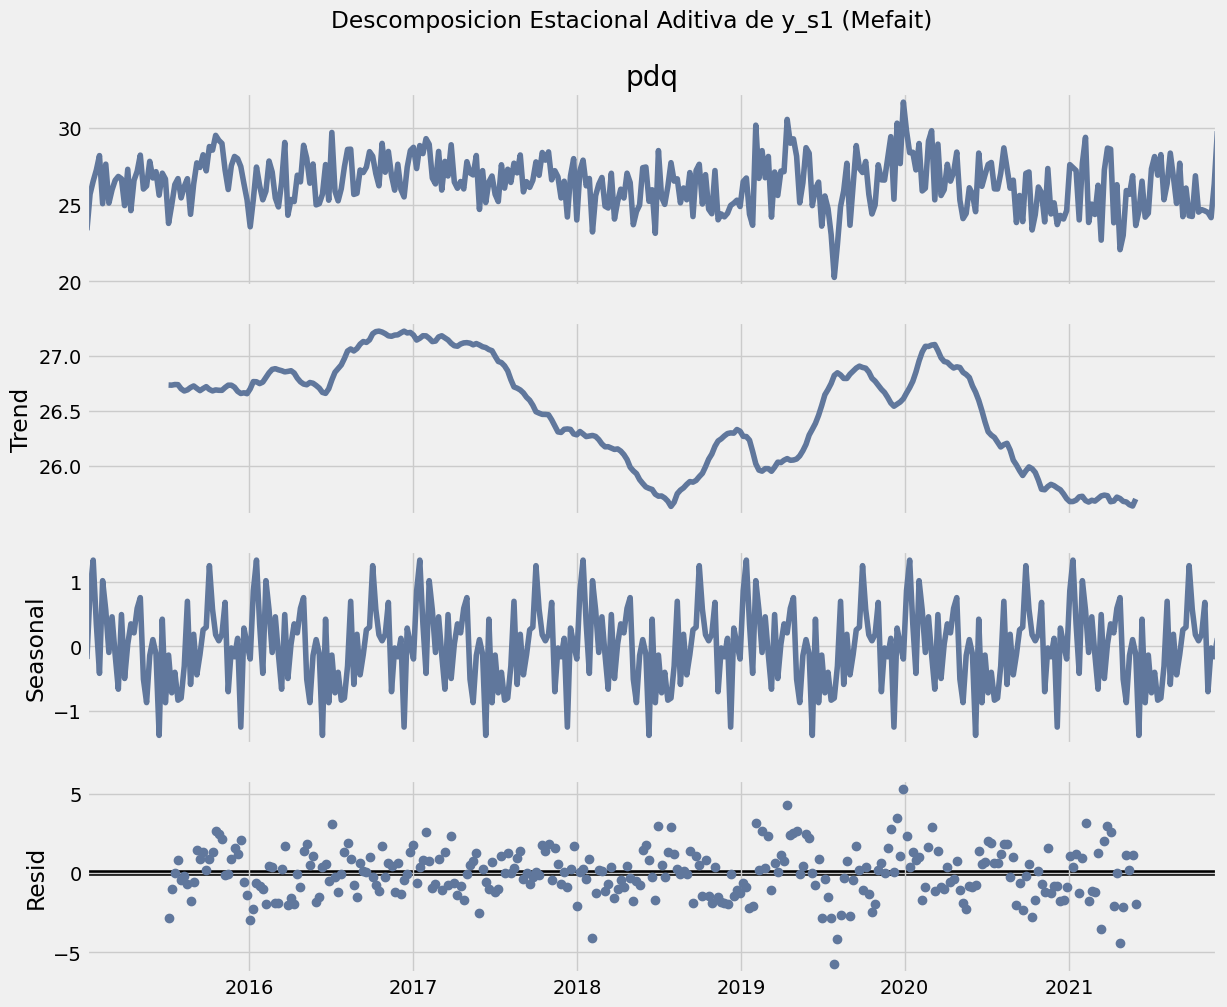


--- Analisis de Autocorrelacion (ACF y PACF) de y_s1 ---


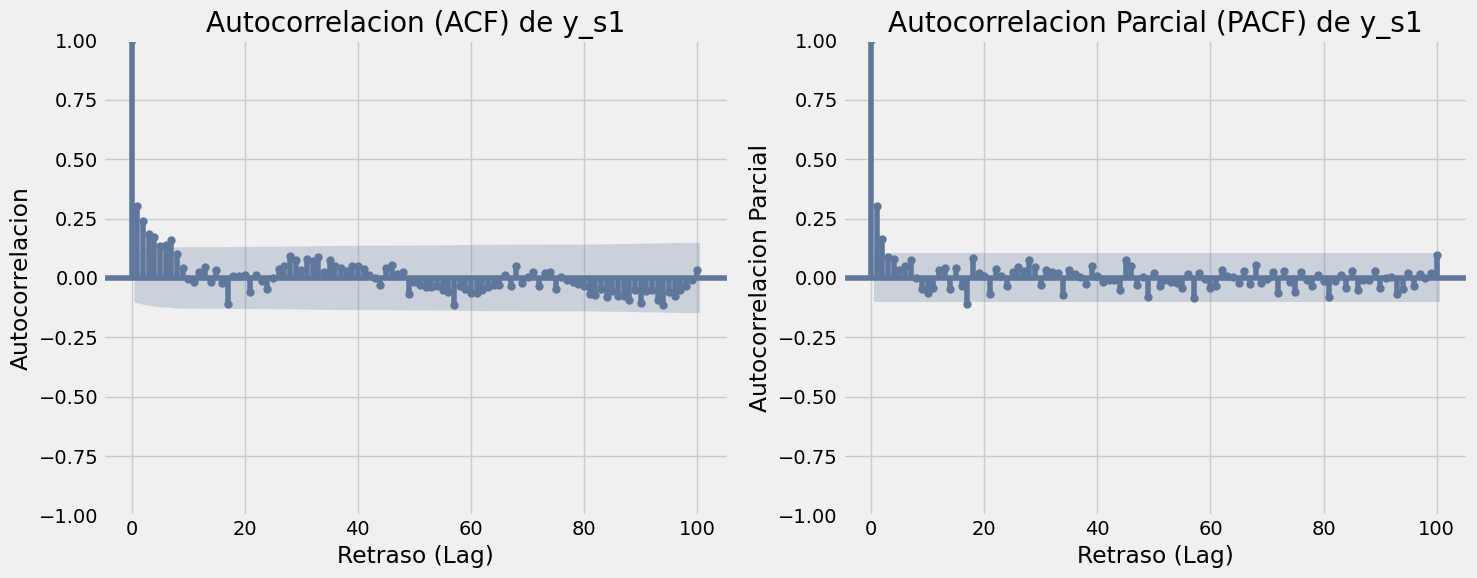

Resultados de la prueba de Dickey-Fuller:
Estadístico de prueba     -6.546213e+00
Valor p                    9.085797e-09
# de retardos usados       3.000000e+00
Número de observaciones    3.570000e+02
dtype: float64

 Se rechaza la hipotesis nula: la serie es estacionaria.


In [95]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pandas as pd
print("--- Grafico de la Serie Temporal y_s1 (Mefait) ---")
y_s1.plot(title='Serie Temporal y_s1: Numero Semanal de Mefait (2015-2020)',figsize=(14, 6))
plt.xlabel("Fecha")
plt.ylabel("Numero de Intervenciones (pdq)")
plt.show()
print("\n--- Descomposicion de la Serie y_s1 (Estacionalidad S=52) ---")
decomposition = sm.tsa.seasonal_decompose(y_s1['pdq'], model='additive', period=52)
fig = decomposition.plot()
fig.set_size_inches(12, 10)
fig.suptitle('Descomposicion Estacional Aditiva de y_s1 (Mefait)', y=1.02)
plt.show()
print("\n--- Analisis de Autocorrelacion (ACF y PACF) de y_s1 ---")
plt.figure(figsize=(15, 6))
plt.subplot(121)
plot_acf(y_s1['pdq'], lags=100, ax=plt.gca(), title='Autocorrelacion (ACF) de y_s1')
plt.xlabel("Retraso (Lag)")
plt.ylabel("Autocorrelacion")
plt.subplot(122)
plot_pacf(y_s1['pdq'], lags=100, ax=plt.gca(), title='Autocorrelacion Parcial (PACF) de y_s1', method='ywm')
plt.xlabel("Retraso (Lag)")
plt.ylabel("Autocorrelacion Parcial")
plt.tight_layout()
plt.show()
print("Resultados de la prueba de Dickey-Fuller:")
resultado = adfuller(y_s1['pdq'], autolag='AIC')
df_output = pd.Series(resultado[0:4],
                      index=['Estadístico de prueba', 'Valor p', '# de retardos usados', 'Número de observaciones'])
print(df_output)
if resultado[1] <= 0.05:
    print("\n Se rechaza la hipotesis nula: la serie es estacionaria.")
else:
    print("\n No se rechaza la hipotesis nula: la serie no es estacionaria.")

In [ ]:
frames = []
for param in params:
    try:
        sarima_model = SarimaModels(param)
        df_metrics = sarima_model.metrics(y_s1,target_date)
        frames.append(df_metrics)
    except:
        pass
df_metrics_result = pd.concat(frames)
df_metrics_result.sort_values(['mae','mape'])
df_best_metrics = df_metrics_result.sort_values(['mae', 'mape']).head(1)
print(df_best_metrics)
print('Vamos a escoger SARIMA_(0,0,0)X(1,0,1,12), por el df_best_metrics')
sarima_model =  SarimaModels([(0,0,0),(1,0,1,12)])
model_fit = sarima_model.fit_model(y_s1,target_date)
best_model = sarima_model.df_testig(y_s1,target_date)
best_model.head()
preds = best_model['yhat']
ax = y_s1["2020":].plot(label='observed')
preds.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('PDQ')
plt.legend()
plt.show()

In [ ]:
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

El análisis de estos cuatro gráficos es muy positivo: esencialmente, nos dicen que los residuos del modelo se comportan perfectamente como ruido blanco. Vemos que los errores son completamente aleatorios, fluctuando alrededor del cero sin mostrar patrones, y el correlograma confirma que no existe autocorrelación alguna entre ellos, lo que es ideal. Además, se cumple el requisito de normalidad, ya que la distribución de los errores se alinea muy bien con la curva normal estándar, según lo muestran el histograma y el gráfico Q-Q. En resumen, el modelo hizo un excelente trabajo al extraer toda la información relevante de la serie.




3. Resuelva el ejercicio anterior utilizando la librería **`Prophet`**, desarrollada por Facebook para el modelado de series temporales.

* **Ajuste del modelo**: entrene un modelo con `Prophet` sobre la misma serie seleccionada en el punto anterior.
* **Evaluación del desempeño**: compare la capacidad predictiva de `Prophet` frente al modelo **SARIMA** previamente ajustado, considerando métricas de error (por ejemplo, MAE, RMSE o MAPE).
* **Análisis comparativo**: discuta las diferencias en los supuestos de ambos métodos, su facilidad de implementación y la calidad de las predicciones obtenidas.
* **Conclusiones**: señale en qué situaciones `Prophet` puede ser preferible a SARIMA y viceversa.


In [ ]:
%pip install cmdstanpy==1.0.1

In [ ]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_train = y_s1.loc[y_s1.index < target_date]
y_test = y_s1.loc[y_s1.index >= target_date]
y_train_prophet = y_train.reset_index()
y_train_prophet.columns = ["ds","y"]
y_test_prophet = y_test.reset_index()
y_test_prophet.columns = ["ds","y"]
print(" Ajuste del Modelo Prophet")
m =Prophet(weekly_seasonality=True,  yearly_seasonality=True, seasonality_prior_scale=10 )
m.fit(y_train_prophet)
dias_a_predecir = (y_test_prophet['ds'].iloc[-1] - y_test_prophet['ds'].iloc[0]).days
future = m.make_future_dataframe(periods=dias_a_predecir, freq='W')
forecast = m.predict(future)
forecast_test = forecast.loc[forecast['ds'].isin(y_test_prophet['ds'])][['ds', 'yhat']]
def mean_absolute_percentage_error(y_true, y_pred):
    """Calcula el error porcentual absoluto medio (MAPE)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def regression_metrics(df):
    """Calcula metricas de evaluacion para modelos de series temporales o regresion."""
    y_true = df['y']
    y_pred = df['yhat']
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    smape = 2 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100
    df_result = pd.DataFrame({
        'MAE': [round(mae, 4)],
        'MSE': [round(mse, 4)],
        'RMSE': [round(rmse, 4)],
        'MAPE': [round(mape, 4)],
        'sMAPE': [round(smape, 4)]})
    return df_result
result = y_test_prophet.merge(forecast_test, on='ds', how='inner')
print("\nMetricas del Modelo Prophet en Conjunto de Prueba ")
df_metrics_prophet = regression_metrics(result)
print(df_metrics_prophet)
preds = result[['ds', 'yhat']].set_index("ds")
preds.index = pd.to_datetime(preds.index)
ax = y_s1[target_date:].plot(label='Observado', figsize=(14, 7))
preds.plot(ax=ax, label='Prediccion', alpha=0.7)
ax.set_xlabel('Fecha')
ax.set_ylabel('PDQ')
plt.title('Prediccion de Prophet vs. Valores Reales en Test')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
sarima_order ="SARIMA_(0,0,0)X(1,0,1,12)"
pd1=df_metrics_result[df_metrics_result["model"] ==sarima_order]
pd2 =regression_metrics(result)
pd2_renamed = pd2.rename(columns={
    'MAE': 'mae',
    'MSE': 'mse',
    'RMSE': 'rmse',
    'MAPE': 'mape',
    'sMAPE': 'smape'})
pd2_renamed['model'] = 'Prophet'
pd2_renamed["mape"] /= 100
cols_to_keep = ['model', 'mae', 'rmse', 'mape', 'smape']
pd1_cleaned = pd1[[col for col in cols_to_keep if col in pd1.columns]]
pd2_cleaned = pd2_renamed[cols_to_keep]
combined_metrics = pd.concat([pd1_cleaned, pd2_cleaned], ignore_index=True)
combined_metrics = combined_metrics[['model', 'mae', 'rmse', 'mape', 'smape']]
print("Tabla Comparativa de Desempeno, SARIM vs prophet")
display(combined_metrics)

El SARIMA mostro una mayor precision (menor MAE, RMSE) en este caso, demostrando ser un modelo estadistico mas robusto para la prediccion, aunque su implementacion es mas compleja y requiere un analisis estadistico profundo (estacionariedad y parametros). Por otro lado, Prophet es mucho mas facil y rapido de implementar, siendo una opcion automatica y flexible para usuarios sin experiencia estadistica, pero resulto ser menos preciso en estos datos, con un error (SMAPE) anormalmente alto.

Ambos modelos tienen su lugar: Prophet es claramente preferible para situaciones donde la facilidad de uso y la interpretacion de componentes (tendencia, estacionalidad, eventos) son clave, siendo ideal para series con mucha volatilidad, cambios de regimen y la necesidad de integrar facilmente eventos externos, funcionando bien incluso con menos conocimientos estadisticos. Por otro lado, SARIMA es superior cuando el objetivo es explotar la estructura de dependencia interna (autocorrelacion), siendo la mejor opcion para series mas estables que cumplen rigurosamente los supuestos de estacionariedad, permitiendo un control estadistico detallado y una inferencia robusta, aunque su implementacion es mas compleja al requerir la identificacion manual de sus ordenes.